README:  
This solves the schrodinger equation for the hydrogen atom using the Verlet Algorithm

First define the ODE from Eq. 19.8 from Feynman's Lecture - The hydrogen atom

\begin{eqnarray}
\frac{1}{r}\frac{d^2}{dr^2}(r\psi) = -\frac{2m}{\hbar^2}(E + \frac{e^2}{r})\psi \\
\psi(\infty) = 0
\end{eqnarray}

Eq. 19.13 changes the scale of the r and E such that 

\begin{equation}
\frac{d^2f}{d\rho^2} = - (\epsilon + \frac{2}{\rho})f ~~,
\end{equation} 

where 
\begin{eqnarray}
\rho = \frac{r}{r_b} \\
\epsilon = \frac{E}{E_r} \\
f = \rho\psi \\
r_b ~~ \text{is the bohr radius} \\
E_r ~~ \text{is the Rydberg energy}
\end{eqnarray}

Boundary condition is $f(\infty) = 0$  
The last equality below is directly from rearranging the defined ODE

Clearly, we don't have the "velocity" (derivative of the psi)  
We therefore cannot use the ivp solver  
  
What we need is an ODE solver that doesn't need the velocity  
Solution: Verlet algorithm  
As per Matt Frick's summary, it solves ODEs using the taylor expansion  
It can solve an ODE by knowing any two points  
This is perfect for radial potentials because we know the points at far distances are zero  
We will then integrate backwards  

From Matt Frick's summary:  
"The Verlet algorithm is a means of calculating the next entry in a differential equation based on a third order Taylor expansion. Consider a differential equation of the form Ψ′′(x) = F[Ψ(x),x].   
By Taylor expanding about a point x, we can find an approximation for the value of Ψ at a distance δx away:  
Ψ(x + δx) = Ψ(x) + δxΨ′(x) + δx2F [Ψ(x), x] + δx3Ψ′′′(x) + O(δx4),   
Ψ(x − δx) = Ψ(x) − δxΨ′(x) + δx2F [Ψ(x), x] − δx3Ψ′′′(x) + O(δx4).  
Combining these equations to elimate the first and third derivatives, we find  
Ψ(x + δx) = 2Ψ(x) − Ψ(x − δx) + 2δx2F [Ψ(x), x], (30)  
which allows us to determine the next step in a series as long as we know the last two steps. Thus, if we know any two steps in a series we can find all the steps in that series by successive use of equation 30. This allows us to easily determine the radial wavefunction of a spherically symmetric system since we know that the radial wavefunction must tend to zero at infinite distances, or in the case of numerics, “large enough” distances." 

So instead of ivp solver, we formulate the verlet algorithm  
We take the system of taylor expansions:  
  
$f(\rho + d\rho) = f(\rho) + dxf'(\rho) + \frac{dx^2f''(\rho)}{2!} + \frac{dx^3f'''(\rho)}{3!} + ...$  
$f(\rho - d\rho) = f(\rho) - dxf'(\rho) + \frac{dx^2f''(\rho)}{2!} - \frac{dx^3f'''(\rho)}{3!} + ...$ 
  
Adding $f(\rho + d\rho)$ and $f(\rho - d\rho)$ together gives a RHS of:  

$f(\rho + d\rho)$ + $f(\rho - d\rho)$ = $2f(\rho) + 2*\frac{dx^2f''(\rho)}{2!}$
  
Rearranging gives the integration equation:  
  
$f(\rho - d\rho)$ = $2f(\rho) - f(\rho + d\rho) + 2\frac{dx^2f''(\rho)}{2!}$ 
  
Notice that in our second order ODE,  
  
$f''(\rho) = - (\epsilon + \frac{2}{\rho})f(\rho)$  
  
And so replacing the $f''(\rho)$ in the integration equation:  
  
$f(\rho - d\rho)$ = $2f(\rho) - f(\rho + d\rho) + 2\frac{dx^2(- (\epsilon + \frac{2}{\rho})f(\rho) )}{2!}$  
  
Thus, if we know a value $f(\rho + d\rho)$ and the value before that, $f(\rho)$, we will know the value at an even earlier point, $f(\rho - d\rho)$.   
  
This allows us to integrate the wavefunction backwards since we know the end values (zero and close to zero)  

Flow chart for defining Verlet function:
1. Set the rho range (called rho) with an increment drho  
2. Initialize an zero list called f to hold the wavefunction - same length as rho  
3. Set the end values of f to be 0 and 10^-10  
4. Define the integration equation from above  
5. Loop over the integration equation, going backwards in index  
6. Normalize f  
7. Return f

Is 1 if theo1 is normalized: 1.000000000000004
Is 1 if theo2 is normalized: 0.9999999999999987
Is 1 if theo3 is normalized: 1.0000000000000018
Is 1 if $\psi$ is normalized: 0.9999999999999964


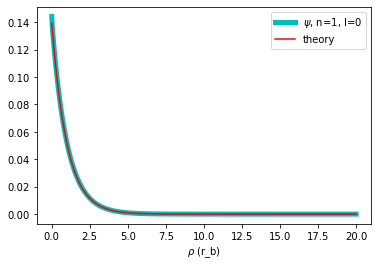

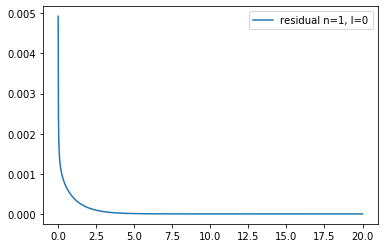

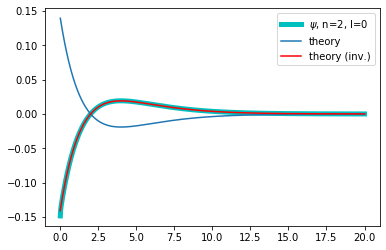

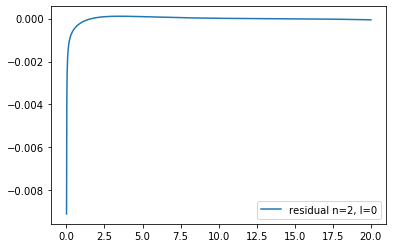

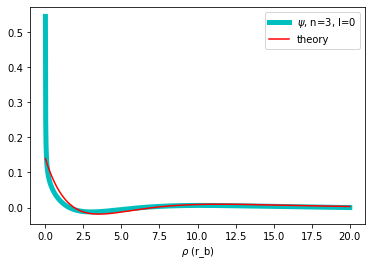

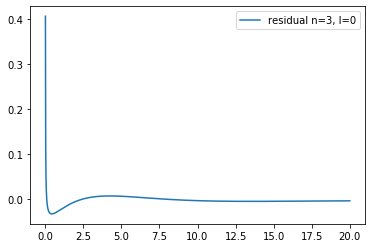

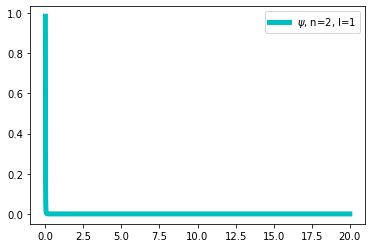

In [19]:
# import packages
import numpy as np
import math

def Verlet(epsilon, l):
    # defining rho range
    totrho = 2000
    rho_min = 0
    rho_max = 20
    rho = np.linspace(rho_min, rho_max, totrho)
    drho = (rho_max)/(totrho)
    
    # initialize a zero list of the wavefunction of length rho
    length = totrho
    f = [0]*length
   
    # set the end values of f; mind the indexing 
    f[length - 1] = 0
    f[length - 2] = 10**-10
    
    for i in range(length-2, 1, -1):
        f[i-1] = 2*f[i] - f[i+1] + drho**2*((-epsilon - 2/rho[i] + l*(l+1)/(rho[i]**2))*f[i])
    
    #print('this is f', f)
    
    psi= [0]*length
    # solve for psi - wavefunction
    for i in range(1, length, 1):
        psi[i] = f[i]/rho[i]
    
    # normalize the wavefunction f
    # find the total sum (A) of all points of f
    A = 0 
    for i in range(length):
        A += psi[i]**2 # should be some factors of pi likely

    Norm = np.sqrt(A)
    psi = [x/Norm for x in psi]
    return psi # normalized wavefunction  


import matplotlib.pyplot as plt
totrho = 2000
rho_min = 0
rho_max = 20
rho = np.linspace(rho_min, rho_max, totrho)


# Theory calc

# n = 1
# Normalize the analytic solution
theo1 = np.exp(-rho)
A = sum([x**2 for x in theo1])
theo1 = [x/np.sqrt(A) for x in theo1]
# Check the psi normalization
print('Is 1 if theo1 is normalized:', sum([x**2 for x in theo1]))

# n = 2
# Normalize the analytic solution
theo2 = (1 - rho/2)*np.exp(-rho/2)
A = sum([x**2 for x in theo2])
theo2 = [x/np.sqrt(A) for x in theo2]
# Check the psi normalization
print('Is 1 if theo2 is normalized:', sum([x**2 for x in theo2]))

# n = 3
# Normalize the analytic solution
theo3 = (1 - 2*rho/3 + 2*rho**2/27)*np.exp(-rho/3)
A = sum([x**2 for x in theo3])
theo3 = [x/np.sqrt(A) for x in theo3]
# Check the psi normalization
print('Is 1 if theo3 is normalized:', sum([x**2 for x in theo3]))

# Calculate the normalized wavefunction
psi = Verlet(-1,0)

# Check the psi normalization
print('Is 1 if $\psi$ is normalized:', sum([x**2 for x in psi]))

# plot n = 1, l=0
plt.plot(rho[1::], psi[1::], label = '$\psi$, n=1, l=0', linewidth = 5, color = 'c')
#plt.plot(rho, rho*psi, label = '$\\rho\psi$')
#plt.plot(rho, [i ** 2 for i in rho*psi], label = '$(\\rho\psi)^2$')
plt.plot(rho[1::], theo1[1::], label = 'theory', color = 'r')
plt.xlabel("$\\rho$ (r_b)")
plt.legend()
plt.show()

# calculating and plotting residuals
res1 = np.subtract(psi, theo1)
plt.plot(rho[1::], res1[1::], label = 'residual n=1, l=0')
plt.legend()
plt.show()

# plot n = 2, l=0
psi = Verlet(-1/4,0)
plt.plot(rho[1::], psi[1::], label = '$\psi$, n=2, l=0', linewidth = 5, color = 'c')
plt.plot(rho[1::], theo2[1::], label = 'theory')
plt.plot(rho, [x*-1 for x in theo2], label = 'theory (inv.)', color = 'r')
plt.legend()
plt.show()

# calculating and plotting residuals
res2 = np.subtract(psi, [x*-1 for x in theo2])
plt.plot(rho[1::], res2[1::], label = 'residual n=2, l=0')
plt.legend()
plt.show()

# plot n = 3, l=0
psi = Verlet(-1/9,0)
plt.plot(rho[1::], psi[1::], label = '$\psi$, n=3, l=0', linewidth = 5, color = 'c')
plt.plot(rho[1::], theo3[1::], label = 'theory', color = 'r')
plt.xlabel("$\\rho$ (r_b)")
plt.legend()
plt.show()

# calculating and plotting residuals
res3 = np.subtract(psi, theo3)
plt.plot(rho[1::], res3[1::], label = 'residual n=3, l=0')
plt.legend()
plt.show()

# plotting p orbitals
psi = Verlet(-1/9, 2)
plt.plot(rho[1::], psi[1::], label = '$\psi$, n=2, l=1', linewidth = 5, color = 'c')
plt.legend()
plt.show()